## Program pengenalan citra wajah

### Arahkan colaboratory pada file project yang ingin dijalankan

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# %cd gdrive/My\ Drive/simple-face-recognition
!ls

dataset		      FaceRecognition.ipynb	 output
dataset2	      FaceRecognition-v2.ipynb	 recognize_video.py
embeddings.txt	      images			 registrasi-training.ipynb
face_detection_model  openface_nn4.small2.v1.t7  registrasi-training-v2.ipynb


### Import libraries yang dibutuhkan

In [0]:
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import matplotlib.pyplot as plt

### Inisialisasi variabel pendukung

In [0]:
dataset = 'dataset'
# embeddings = 'output/embeddings.pickle'
recognizer_model = 'output/recognizer.pickle'
label_encoder = 'output/le.pickle'
image = 'images/adrian.jpg'

### Model pendeteksi wajah

In [0]:
protoPath = 'face_detection_model/deploy.prototxt'
modelPath = 'face_detection_model/res10_300x300_ssd_iter_140000.caffemodel'
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

### Model pengekstraksi fitur

In [0]:
embedding_model = 'openface_nn4.small2.v1.t7';
embedder = cv2.dnn.readNetFromTorch(embedding_model)

### Model pengenalan citra wajah

In [40]:
f = open(label_encoder, "rb")
le = pickle.loads(f.read())
f.close()
print(le)

f = open(recognizer_model, "rb")
recognizer = pickle.loads(f.read())
f.close()
print(recognizer)

LabelEncoder()
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### Preprocessing data yang akan dites

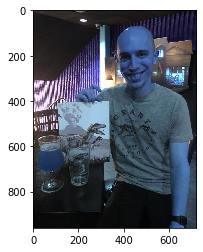

In [41]:
# load the image, resize it to have a width of 600 pixels (while maintaining the aspect ratio), and then grab the image dimensions
image = cv2.imread(image)
plt.imshow(image)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),	(104.0, 177.0, 123.0), swapRB=False, crop=False)

# apply OpenCV's deep learning-based face detector to localize faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()

### Proses testing

In [0]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the
		# face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]

		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue

		# construct a blob for the face ROI, then pass the blob through our face embedding model to obtain the 128-d quantification of the face
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),	(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()

		# perform classification to recognize the face
		preds = recognizer.predict_proba(vec)[0]
		j = np.argmax(preds)
		proba = preds[j]
		name = le.classes_[j]

		# draw the bounding box of the face along with the associated probability
		text = "{}: {:.2f}%".format(name, proba * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),	cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

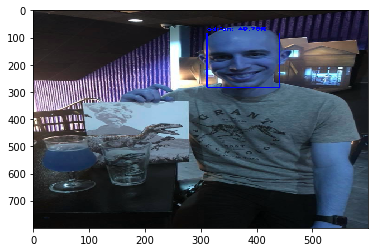

In [44]:
# show the output image
plt.imshow(image, aspect='auto')